<h1><center>CMPE 462 - Project 3 <br>Implementing K-Means & PCA<br>Due: June 14, 2020, 23:59</center></h1>

- **Student ID1:** **2014400066**
- **Student ID2:** **2014400117**
- **Student ID3:** **2014400042**

# Overview

In this project, you are going to implement two unsupervised learning techniques. In the first task, you are asked to implement **k-means clustering** algorithm using the data provided in `kmeans_data.zip`. In the second task, you need to implement **PCA** and apply dimensionality reduction on the data provided in `USPS.mat`. 

Overall notebook structure is below:
* [K-Means Clustering](#k_means_general)
    * [Plot Clusters](#k_means_data_visualization)
    * [K-Means Implementation](#k_means_implementation)
    * [Evaluation](#k_means_eval)
* [Principal Component Analysis (PCA)](#pca_general)
    * [PCA Implementation](#pca_implementation)
    * [Image Reconstruction](#image_reconstruction)
    * [Evaluation](#pca_eval)

In [1]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (5,5)
np.random.seed(9)


Bad key "text.kerning_factor" on line 4 in
/Users/sadullahgultekin/miniconda3/envs/pytorch-1.4/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


<a id='k_means_general'></a>
# (50 pts) Task 1: K-Means Clustering

Please download `kmeans_data.zip`. In this problem, ground truth cluster assignments are given in `labels.npy`. 

<a id='k_means_data_visualization'></a>
## (10 pts) Task 1.1: Plot Clusters

Plot the data using scatter plot. Assign different colors to different classes.

In [2]:
# Load the data
data = np.load('kmeans_data/data.npy')
label = np.load('kmeans_data/label.npy')

In [3]:
# Split the data wrt class label
class_0_data = data[label == 0]
class_1_data = data[label == 1]
class_2_data = data[label == 2]

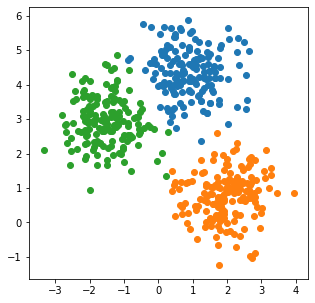

In [4]:
# Scatter whole data according to their class label
plt.scatter(class_0_data[:,0], class_0_data[:,1])
plt.scatter(class_1_data[:,0], class_1_data[:,1])
plt.scatter(class_2_data[:,0], class_2_data[:,1])
plt.show()

<a id='k_means_implementation'></a>
## (30 pts) Task 1.2: K-Means Implementation

Implement k-means clustering algorithm by yourself using the number of iterations as the stopping condition. You can use built-in functions only for side-tasks such as norm computation, minimum element search and mean calculation, not for the clustering itself.

In [5]:
class KMeans():
    """
    Implements K-Means algorithm for any cluster number.
    Uses euclidean distance (L-2 Norm) to calculate the distance 
    between data points.
    """
    def __init__(self, n_clusters=3, n_iter=9, max_iter=300, tol=0.001, verbose=False, seed=1):
        """
        Initialize the K-Means clustering object.
        
        Parameters
        ----------
        n_clusters : int, default=3
            Number of the clusters.
        n_iter : int, default=9
            Number of iteration that is desired to run the algorithm.
        max_iter : int, default=300
            Maximum iteration number that the algorithm is allowed to run.
        tol : float, default=0.001
            Tolerance for the overall distance. If the tolerance is too high,
            the algorithm will be ended without finding the optimal clusters.
            If it is too low, algorithm will run even after finding the optimal
            clusters.
        verbose : bool, default=False
            Whether to show the distance in training process or not.
        """
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.n_iter = n_iter
        self.tol = tol
        self.verbose = verbose
        self.iter_counter = 0
        self.seed = seed
        self.centroids = None
        self.belonging = None
        self.prev_dist = np.inf
        self.current_dist = 0
    
    def initialize(self, data):
        """
        Initializes the centroids and belonging array which shows which data
        point belongs to which centroid. This array is initialized with zeros
        which mean all data points are belong to the first class. However, at 
        the first iteration of the training, proper values will be assigned to
        the array.
        
        Parameters
        ----------
        data : numpy.ndarray
            Data points with shape (num_of_data, 2).
        """
        # To get the same initial assingments for different runs
        np.random.seed(self.seed)
        
        # Find the min and max values for centroids
        x_min, x_max = np.min(data[:,0]), np.max(data[:,0])
        y_min, y_max = np.min(data[:,1]), np.max(data[:,1])
        
        # Randomly generate points that will work as centroids
        x_vals = np.random.uniform(x_min, x_max, self.n_clusters)
        y_vals = np.random.uniform(y_min, y_max, self.n_clusters)
        
        # Reshape the points to get a shape like list of points
        self.centroids = np.vstack((x_vals, y_vals)).T.reshape(-1,2)
        
        # Fill belongings array using assing_cluster function which will assign
        # a class to each data point
        self.assign_clusters(data)
        
    def visualize_data(self, data, axis=None, N=None, title=None):
        """
        Visualize the current clustering information into a scatter plot.
        If the axis, N, and title parameters are not given, single scatter
        plot that shows all clusters will be generated. Otherwise, generated
        scatter plot will be placed to the given axis object, using the 
        given title.
        
        Parameters
        ----------
        data : numpy.ndarray
            Data points with shape (num_of_data, 2).
        axis : numpy.ndarray, default=None
            Axis objects that will keep the subplots.
        N : int, default=None
            Axis indice of the subplot. Shows which part of the general plot
            will be filled with generated scatter plot.
        title : str, default=None
            Title for the generated subplot.
        """
        # For each cluster scatter all points
        for cluster in range(self.n_clusters):
            # Extract the related data points
            cluster_data = data[self.belonging == cluster]

            if axis is None:
                # If subplot is not being created, scatter all related data points
                plt.scatter(cluster_data[:,0], cluster_data[:,1])
            else:
                # If subplot is being created, scatter all related data points to 
                # given axis of subplot
                axis[N].scatter(cluster_data[:,0], cluster_data[:,1])
        
        # Add centroid to the plots
        if axis is None:
            plt.scatter(self.centroids[:,0], self.centroids[:,1], s=200, marker='X')
        else:
            axis[N].scatter(self.centroids[:,0], self.centroids[:,1], s=200, marker='X')
            axis[N].set_title(label=f"Iteration {N}")

        
    def assign_clusters(self, data):
        """
        Calculates the distance between each centroid and each data point, 
        and assings new belongings to each datapoint.
        
        Parameters
        ----------
        data : numpy.ndarray
            Data points with shape (num_of_data, 2).
        """
        # Repeat the data with the number of clusters to vectorize the calculation process.
        repeated_data = np.dstack([data] * self.n_clusters).transpose(0,2,1)
        
        # Calculate the belonging for all datapoints
        self.belonging = np.argmin(np.sum((repeated_data - self.centroids)**2, axis=2), axis=1)
    
    def recompute_centroids(self, data):
        """
        For each cluster calculates a new centroid by taking the mean of 
        each cluster. After calculating new centroids, calculates euclidian 
        distance for each data point and sums them up to get overall distance.
        Returns the calculated overall distance
        
        Parameters
        ----------
        data : numpy.ndarray
            Data points with shape (num_of_data, 2).
            
        Return
        ----------
        totol_distance : float
            Calculated overall distance.
        """
        # Class number for each cluster
        classes = np.array(range(self.n_clusters))
        
        # Calculate the centroid for each class seperately and fill them into a list
        # This list will become new centroids in the next interation
        centroids = []
        for i in range(self.n_clusters):
            centroids.append(np.mean(data[self.belonging == classes[i]], axis=0))
        self.centroids = np.array(centroids)
        
        # Calculate the overall distance
        repeated_data = np.dstack([data] * self.n_clusters).transpose(0,2,1)
        all_dists = np.sqrt(np.sum((repeated_data - self.centroids)**2, axis=2))
        cluster_based_dists = all_dists[range(data.shape[0]), self.belonging]
        total_distance = np.sum(cluster_based_dists)
        
        # Set current distance as calculated overall distance
        self.current_dist = total_distance

    def print_distance(self):
        """
        Logging function.
        """
        if self.verbose:
            print(self.current_dist)

    def stop_iteration_criterion(self):
        """
        Iteration number related stopping criterion for training loop.
        """
        return self.iter_counter != self.n_iter  and self.iter_counter != self.max_iter

    def stop_distance_criterion(self):
        """
        Distance related stopping criterion for training loop.
        """
        return self.tol is not None and self.prev_dist - self.current_dist < self.tol
    
    def fit(self, data):
        """
        Training function of K-Means clustering algorithm. Takes only the data
        and tries to split it into N cluster which is given in the initialization 
        function. Runs until one of the following condiitons fulfilled:
            - Number of iteration gets equal to number of iteration defined by the user
            - Number of iteration reaches to the maximum number of iteration
            - Overall change in the distance gets smaller than the tollerance value
        
        Parameters
        ----------
        data : numpy.ndarray
            Data points with shape (num_of_data, 2).
        """
        # Initialize the model
        self.initialize(data)

        # Run until n_iter or max_iter
        while self.stop_iteration_criterion():
            
            # Recompute the centroids
            self.recompute_centroids(data)
            
            # Assing new clusters for each data
            self.assign_clusters(data)

            # Print the current overall distance
            self.print_distance()
                
            # Stop the training if conditions are fulfilled
            if self.stop_distance_criterion():
                break
            
            # Update current distance
            self.prev_dist = self.current_dist

            # Increament the counther to keep track of stopping criterion
            self.iter_counter += 1
            

<a id='k_means_eval'></a>
## (10 pts) Taks 1.3: Evaluation

Run k-means $9$ times with number of iterations $(N)$ $= \{1, 2, ..., 9\}$. Plot the final clustering assignments as a scatter plot for each run as 3x3 `matplotlib subplot`. Visually investigate the effect of the number of iterations on obtaining the optimal clustering and find the convergence point by comparing the plots with the one in Task 1.1. If the model does not converge at $9$ iterations, you can select $9$ other $N$ to effectively show the progress of the clustering.

For a fair comparison, start each run with the same initial random assignments. You can use `np.random.seed(1)` to this purpose.

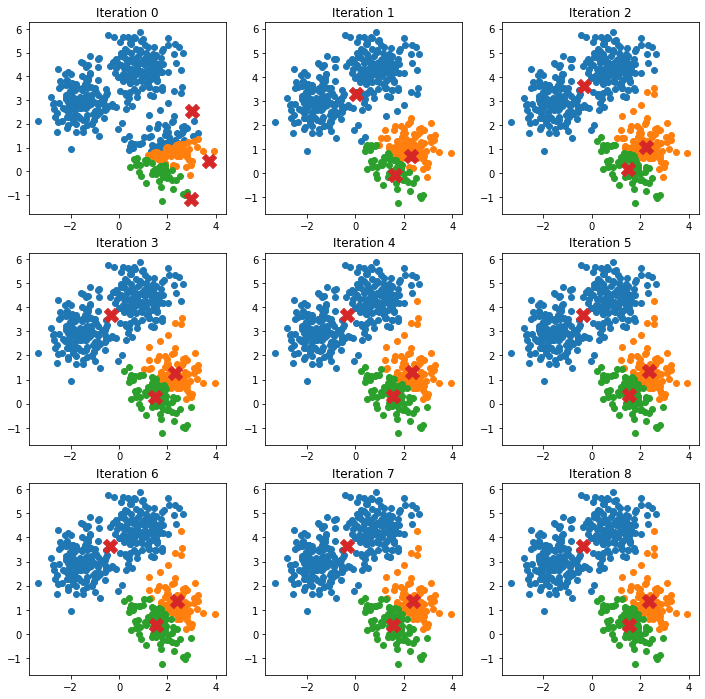

In [6]:
# Create figure with 9 subplots that will hold seperate iteration of K-Means algorithm
fig, axis = plt.subplots(3,3, figsize=(12, 12))
axis = axis.ravel()

# Run K-Means 9 times
for N in range(0,9):
    # Create K-Means object with given specific of iteration
    # Try with seed 1 and 8 for different results
    kmeans = KMeans(n_iter=N, seed=8)
    
    # Fit the data
    kmeans.fit(data)
    
    # Visualize the cluster information
    kmeans.visualize_data(data, axis, N)

<a id='pca_general'></a>
# (50 pts) Task 2: Principal Component Analysis (PCA)

Please load the whole dataset in `USPS.mat` using the function `loadmat` in `Scipy.io`. The matrix $A$ contains all the images of size 16 by 16. Each of the 3000 rows in $A$ corresponds to the image of one handwritten digit (between 0 and 9).

<a id='pca_implementation'></a>
## (30 pts) Task 2.1: PCA Implementation

Implement PCA and apply it to the data using $d = 50, 100, 200, 300$ principal components. You are not allowed to use an existing implementation. You can use existing packages for eigen-decomposition. **Do not forget to standardize the data before eigen-decomposition.**

In [7]:
import scipy.io as sio
from scipy import linalg
plt.rcParams["figure.figsize"] = (10,10)

In [8]:
# Load the data
usps_data = sio.loadmat("USPS.mat")

# Extract data and label
data = usps_data['A']
label = usps_data['L']

In [9]:
class PCA():
    """
    Implements principal component analysis.
    """
    def __init__(self, n_components=2):
        """
        Initialize the PCA object.
        
        Parameters
        ----------
        n_components : int, default=2
            Number of principal components that will be used in PCA.
            Lower n_components will result with poor quality image reconstructions.
        """
        self.n_components = n_components
        
        # When fit function is called, transformation matrix will be held in this variable
        self.transformation = None
        
    def transform(self, x):
        """
        Applies the transformation to given data.
        
        Parameters
        ----------
        x : numpy.ndarray
            Data that will be transformed.
        """
        return np.matmul(x, self.transformation)
    
    def inverse_transform(self, x):
        """
        Applies an inverse transformation to given data
        
        Parameters
        ----------
        x : numpy.ndarray
            Data that will be transformed back to the original form.
        """
        return np.matmul(x, self.transformation.T)
    
    def normalize(self, x):
        """
        Normalizes the given data into 0 mean 1 std

        Parameters
        ----------
        x : numpy.ndarray
            Data that will be normalized.
            
        Return
        ----------
        totol_distance : float
            Calculated overall distance.
        """
        return (x - np.mean(x, axis=0)) / np.std(x, axis=0)
    
    def fit(self, x):
        """
        Training function for PCA algorithm. Takes the data and finds a transformation
        matrix which is assigned to a class variable. Number of principal components
        should be given in the initialization part. 
        
        Parameters
        ----------
        x : numpy.ndarray
            Data that will be used to calculate principal components.
        """
        # Normalizes into 0 mean, 1 std
        x = self.normalize(x)
        
        # Covariance matrix of x
        covariance_matrix = np.matmul(x.T,x) / x.shape[1]
        
        # Eigenvectors of covariance matrix
        eigenvectors = linalg.eig(covariance_matrix)[1]
        
        # N principal components 
        pcs = eigenvectors[:self.n_components]
        
        # Transformation
        self.transformation = pcs.T

In [10]:
# Number of principal components
ds = 50, 100, 150, 200, 256

# List to keep all PCA objects and their transformation results
all_pca = []
for d in ds:
    # Init the PCA objects
    pca = PCA(n_components=d)
    
    # Fit the data
    pca.fit(data)
    
    # Apply the transformation 
    transformed_data = pca.transform(data)
    
    # Collect the PCA object and transformed data
    all_pca.append((pca, transformed_data))

<a id='image_reconstruction'></a>
## (15 pts) Task 2.2: Image Reconstruction

Reconstruct images using the selected principal components from Task 2.1

In [11]:
all_reconstructed_data = []
# Iterate all PCA objects and their corresponding transformed data
for pca, transformed_data in all_pca:
    # Apply inverse transform
    reconstructed_data = pca.inverse_transform(transformed_data)
    # Collect reconstructed images
    all_reconstructed_data.append(reconstructed_data)

<a id='pca_eval'></a>
## (5 pts) Task 2.3: Evaluation

Visualize the reconstructed images for the images at indices $i = 0, 500, 1000, 2000$ for $d=50, 100, 200, 300$. Create a 4x5 subplot where the rows correspond to images at each index, first four columns correspond to reconstructed images using each $d$ and the last column is the raw image, i.e. before PCA. Comment on your results.

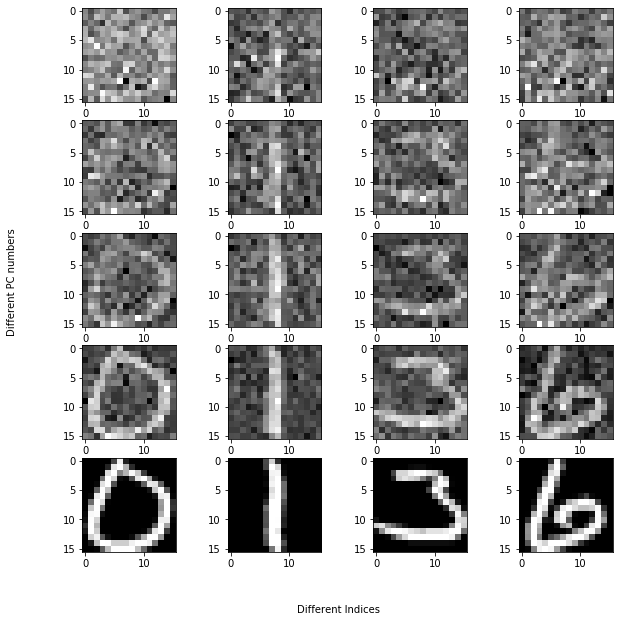

In [12]:
# Create figure to show reconstrcuted images
fig, axarr = plt.subplots(5,4)
fig.text(0.5, 0.04, 'Different Indices', ha='center')
fig.text(0.04, 0.5, 'Different PC numbers', va='center', rotation='vertical')

# Indices to select images from all dataset
indices = [0, 500, 1000, 2000]

# Show reconstructed images
for i, reconstructed_data in enumerate(all_reconstructed_data):
    for j, ind in enumerate(indices):
        axarr[i,j].imshow(all_reconstructed_data[i][ind].reshape(16,16), cmap="gray")